### About project

In this little learning project, I’m going to take advantage of the bootstrap to estimate the bias and spread of machine learning algorithms.

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [7]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

In [8]:
X.shape, y.shape

((506, 13), (506,))

### Calculating bias and variation using bootstrap
By simple transformations, we can derive the following formula showing how the error of the regression algorithm can be represented as the sum of three components:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] =
$$
$$
\underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x])^2\bigr]}_{\text{noise}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{offset}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)])^2\bigr]\bigr]}_{\text{spread}},
$$
*$\mu(X)$ — algorithm trained on the sample $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — the answer of the algorithm trained on the sample $X$ on the object $x$;
* $\mathbb{E}_{X}$ — mat. expectation for all possible samples;
* $\mathbb{E}_{X}[\mu(X)(x)]$ is the "average" response of the algorithm trained on all possible samples of $X$ on the object $x$.
    
Using this formula, we can analyze the properties of the $\mu$ model learning algorithm if we set a probabilistic model for generating pairs of $p(x,y)$.

In real problems, of course, we do not know the distribution on pairs of object - the correct answer. However, we have a set of samples from this distribution (a training sample), and we can use it to evaluate mathematical expectations. To evaluate the expectation. We will use bootstrap, a method of generating "new" samples from one by selecting objects with a return. Let's analyze a few steps on the way to estimating the bias and spread.

#### Approximate calculation of integrals
There are examples of analytical calculation of bias and spread of several learning algorithms. For most data models and learning algorithms, it will not be possible to analytically calculate mathematical expectations in formulas. However, math expectations can be estimated approximately. To estimate the mathematical expectation $\mathbb{E}_{\bar z} f(\bar z)$ of a function of a multidimensional random variable $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, you can generate a sample from the distribution $p(\bar z)$ and average the value of the function on the elements of this sample:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

For example, let's estimate $\mathbb{E}_z z^2,$$z\sim\mathcal{N}(\mu=5, \sigma=3)$ (from probability theory we know that
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.932175246772296

#### Evaluation $\mathbb{E}_{x, y}$
Rate the mat. the expectations for $x$ and for $x, y$ occurring in all three components of the decomposition are not difficult, because we have a sample of objects from the data distribution $p(x,y)$:
$$ \mathbb{E}_{x}f(x)\approx\frac 1 N\sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x,y}f(x,y) \approx\frac 1 N\sum_{i=1}^N f(x_i, y_i),$$
where $N$ is the number of objects in the sample, $\{(x_i, y_i)\}_{i=1}^N$ is the selection itself. 

#### Evaluating $\mathbb{E}_X$ with a bootstrap
To evaluate the mate. waiting for $X$, we will need a sample from the samples:
$$\mathbb{E}_X f(X) \approx\frac 1 s\sum_{j=1}^s f(X_j),$$
where $X_j$ is the $j$-th sample. To get them, we can use bootstrap, a method of generating samples based on the selection of objects with a return. To make one selection, we will select the index of the object $i\sim\text{Uniform}(1\dots N)$$N times and add the $i$th pair (object, target variable) to the selection. As a result, duplicate objects may appear in each sample, and some objects may not be included in some samples at all.

#### The final algorithm for estimating the offset and spread of the algorithm $a$
1. Generate $s$ samples of $X_j$ by bootstrap method.
1. On each sample $X_j$, train the algorithm $a_j$.
1. For each sample $X_j$, determine the set of objects $T_j$ that are not included in it (out-of-bag). Calculate predictions of the algorithm $a_j$ on objects $T_j$. 

Since we have only one answer for each object, we will consider the noise equal to 0, and $\mathbb{E}[y|x]$ equal to the available correct answer for the object $x$. 

Final grades:
* Offset: for one object - the square of the difference between the average prediction and the correct answer. The average prediction is taken only by those algorithms $a_j$ for which this object was included in the out-of-bag sample $T_j$. To get the total offset, perform averaging of offsets across objects.
* Spread: for one object - the sample variance of predictions of algorithms $a_j$, for which this object was included in the out-of-bag sample $T_j$. To get the total spread, perform averaging of the spreads by objects.
* Error $L$: Average the squares of the prediction and correct answer differences over all the predictions made for all objects.

As a result, it should turn out that the error is approximately equal to the sum of the offset and the spread!

The algorithm is also briefly described at [link](https://web.engr.oregonstate.edu /~tgd/classes/534/slides/part9.pdf) (slides 19-21).

### 1. Bias variance decomposition algorithm implementation

In [13]:
from sklearn.utils import resample # for Bootstrap sampling

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [11]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    index_set = set(np.arange(X.shape[0]))
    pred = np.full((num_runs, X.shape[0]), fill_value=np.inf)
    error_matrix = np.zeros(num_runs)
    
    for i in range(num_runs):
        bootstrap_index = np.random.randint(0, X.shape[0], X.shape[0])
        out_of_bag_index = list(index_set.difference(bootstrap_index))
        
        regressor.fit(X[bootstrap_index], y[bootstrap_index])
        y_pred = regressor.predict(X[out_of_bag_index])
        
        pred[i][out_of_bag_index] = y_pred
        error_matrix[i] = np.mean((y_pred - y[out_of_bag_index])**2)
    
    pred = np.where(pred != np.inf, pred, np.nan)
    bias = np.nanmean((np.nanmean(pred, axis=0) - y)**2)
    variance = np.nanmean(np.nanvar(pred, axis=0)) 
    error = np.mean(error_matrix)
    return bias, variance, error
    

### 2. Computing biase, variance and error for LinReg, DecTree and RandForest

In [104]:
def add_row(dataframe, algorithm_name, algorithm):
    bias, variance, error = algorithm
    dataframe = pd.concat([dataframe, pd.DataFrame([[algorithm_name, bias, variance, error]], 
                                columns=['algorithm', 'bias', 'variance', 'error'])], ignore_index=True)
    return dataframe

In [105]:
bias, variance, error = compute_biase_variance(LinearRegression(), X, y)
result = pd.DataFrame(['LinearRegression', bias, variance, error]).T.rename(columns={
    0: 'algorithm', 
    1: 'bias', 
    2: 'variance', 
    3: 'error'
})
result = add_row(result, 'DecisionTreeRegressor', compute_biase_variance(DecisionTreeRegressor(), X, y))
result = add_row(result, 'RandomForestRegressor', compute_biase_variance(RandomForestRegressor(), X, y))
result

,algorithm,bias,variance,error
0,LinearRegression,23.738007,0.927378,24.593968
1,DecisionTreeRegressor,10.17238,13.012499,23.056723
2,RandomForestRegressor,10.646989,2.263737,12.915503


### Conclusion 
+ DecTree and RandForest can find nonlinear dependencies between features and target so they predict target variable more accurately and have less bias than LinReg 
+ LinReg has the smallest spread, because it has simple structure and its weights aren’t very sensitive to data changes.
+ RandForest has a variance smaller than DesTree, because it averages the predictions of multiple trees and data changes have less effect on forest predictions than on tree

**Overall:** Our data supports the theory

### 4. Bagging
Let's build a bagging over all three models (linear regression, decision tree, random forest).

**Bagging:**

+ Let there be some method of learning $\mu(X)$.

Let's build on its basis the method $\tilde\mu(X)$, which
generates a random subsample of $\tilde X$ using a bootstrap
and feeds it to the input of the method $\mu$: $\tilde\mu(X) = \mu(\tilde X)$.

Recall that bootstrap is a sampling of $\ell$ objects from a sample
with a return, as a result of which some objects are selected several
once, and some never.

Placing several copies of one object in the bootstrapped selection
corresponds to setting the weight for this object - the corresponding
term will enter the functionality several times, and therefore the penalty
for an error on it will be greater.

In bagging (bootstrap aggregation), it is proposed to train a certain
number of algorithms $b_n(x)$ using the method $\tilde \mu$, and build the final composition
as the average of the data of the basic algorithms:

$a_N(x)
    =
    \frac{1}{N}
    \sum_{n = 1}^{N}
        b_n(x)
    =
    \frac{1}{N}
    \sum_{n = 1}^{N}
        \tilde \mu(X)(x)$

If the underlying algorithms are uncorrelated, then **the variance of the composition is N
times less than the variance of the individual algorithms**. If there is a correlation, then
the decrease in variance may be much less significant.

In [107]:
from sklearn.ensemble import BaggingRegressor


In [108]:
result = add_row(result, 'Bagging on LinearRegression',
                 compute_biase_variance(BaggingRegressor(LinearRegression()), X, y))
result = add_row(result, 'Bagging on DecisionTreeRegressor',
                 compute_biase_variance(BaggingRegressor(DecisionTreeRegressor()), X, y))
result = add_row(result, 'Bagging on RandomForestRegressor',
                 compute_biase_variance(BaggingRegressor(RandomForestRegressor()), X, y))
result

,algorithm,bias,variance,error
0,LinearRegression,23.738007,0.927378,24.593968
1,DecisionTreeRegressor,10.17238,13.012499,23.056723
2,RandomForestRegressor,10.646989,2.263737,12.915503
3,Bagging on LinearRegression,23.732603,1.042624,24.873646
4,Bagging on DecisionTreeRegressor,10.777248,3.456984,14.367525
5,Bagging on RandomForestRegressor,11.666071,1.367366,13.00549


### 5. Visualization of predictions of basic bagging algorithms

Implementing the plot_predictions function. It will perform the following actions:
1. Randomly select num_test_objects object-target variable pairs from the sample X, y. You will get two samples: a small X_test, y_test (selected test objects) and X_train, y_train (other objects).
2. Generate num_runs of samples by bootstrap method from X_train, y_train. Train the regressor algorithm on each sample and make predictions for X_test.
3. Draw a scatter chart. On the abscissa axis - test sample objects (numbers from 0 to num_test_objects-1), on the ordinate axis - predictions. As a result, you will get num_test_objects of columns with dots. For each test object, mark all predictions for it in one color, and also mark the correct answer in black.

In [1]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    pred = []
    index_set = set(np.arange(X.shape[0]))
    test_index = np.random.randint(0, X.shape[0], num_test_objects)
    X_test, y_test = X[test_index], y[test_index]
    X_train, y_train = X[list(index_set.difference(test_index))], y[list(index_set.difference(test_index))]
    
    for i in range(num_runs):

        bootstrap_index = np.random.randint(0, X_train.shape[0], X_train.shape[0])

        reg = regressor.fit(X_train[bootstrap_index], y_train[bootstrap_index])
        pred.append(reg.predict(X_test))
        plt.scatter(np.arange(num_test_objects), pred[i], c='darkkhaki', alpha=0.4)
    plt.scatter(np.arange(num_test_objects), y_test, c='black')
    plt.ylim(0, 60)
    plt.xlabel('Objects')
    plt.ylabel('Target')
    plt.title(title)

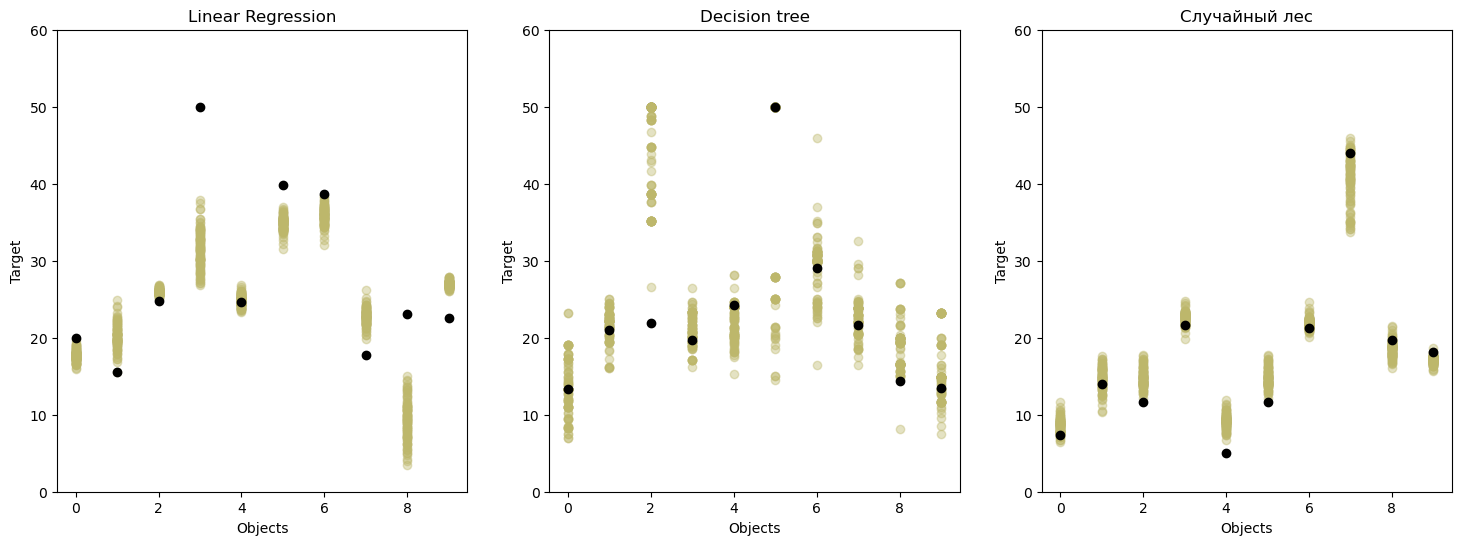

In [9]:
fig = plt.figure(figsize=(18, 6))

plt.subplot(1,3,1)
plot_predictions(LinearRegression(), X, y, title='Linear Regression')

plt.subplot(1,3,2)
plot_predictions(DecisionTreeRegressor(), X, y, title='Decision tree')

plt.subplot(1,3,3)
plot_predictions(RandomForestRegressor(n_jobs=-1), X, y, title='Случайный лес')

+ LinReg makes shifted predictions, but biase is low
+ DecTree зredicts target variable with good accuracy, but the value changes quite strongly
+ RandForest - the king

### Changing bias and variation when changing hyperparameters

We will construct graphs of correlation of offset and scatter from hyperparameters of the decisive tree max_depth (from 1 to 10) and max_features (from 1 to X.shape[1]):

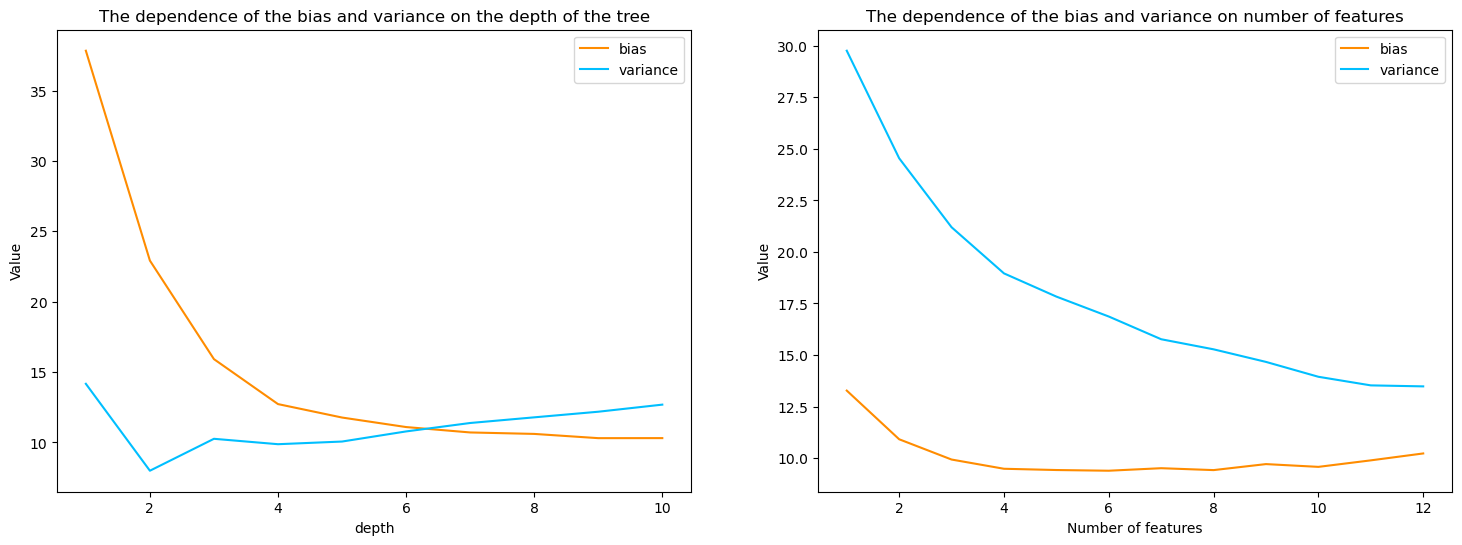

In [14]:
max_depth = np.arange(1, 11)
max_features = np.arange(1, X.shape[1])
depth_bias = []
depth_variance = []
features_bias = []
features_variance = []

for depth in max_depth:
    bias, variance, error = compute_biase_variance(DecisionTreeRegressor(max_depth=depth), X, y)
    depth_bias.append(bias)
    depth_variance.append(variance)

fig = plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)
plt.plot(max_depth, depth_bias, c='darkorange', label='bias')
plt.plot(max_depth, depth_variance, c='deepskyblue', label='variance')
plt.legend()
plt.xlabel('depth')
plt.ylabel('Value')
plt.title('Dependence of the bias and variance on the depth of the tree')

for feature in max_features:
    bias, variance, error = compute_biase_variance(DecisionTreeRegressor(max_features=feature), X, y)
    features_bias.append(bias)
    features_variance.append(variance)

plt.subplot(1,2,2)
plt.plot(max_features, features_bias, c='darkorange', label='bias')
plt.plot(max_features, features_variance, c='deepskyblue', label='variance')
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('Value')
plt.title('Dependence of the bias and variance on number of features')

plt.show()

Let's plot the dependence of the offset and spread on n_estimators (on a grid of 2*np.arange(1, 10)) for a random forest and gradient boosting:

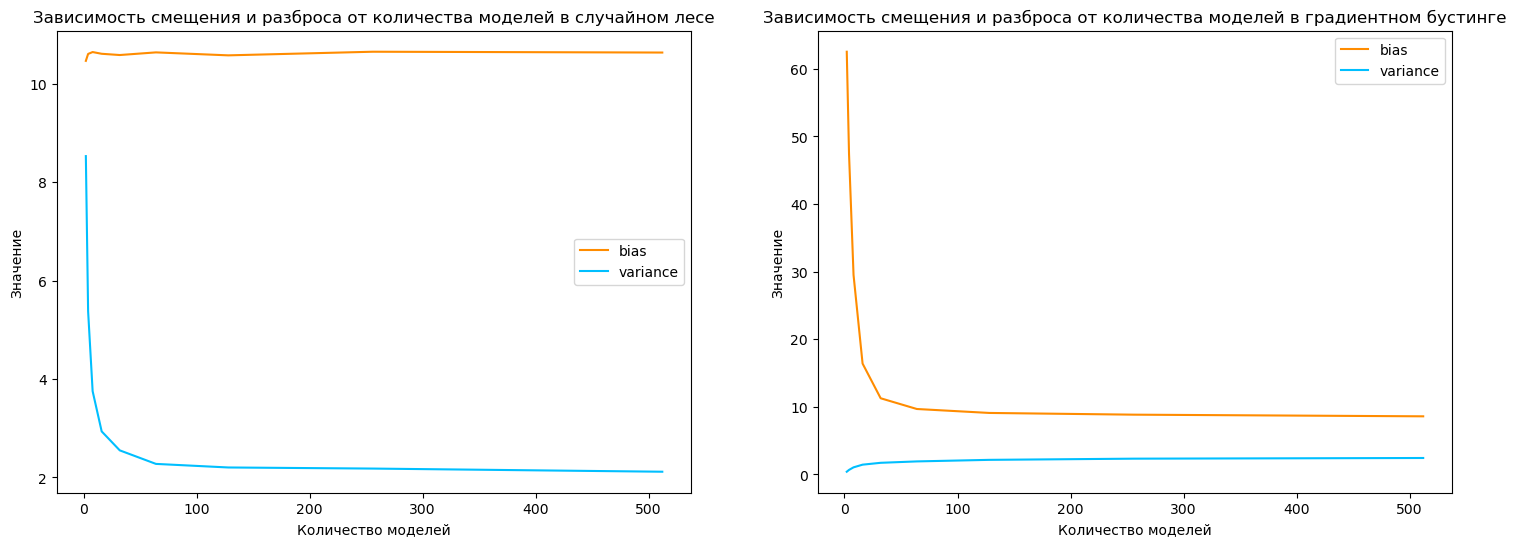

CPU times: total: 1h 41min 19s
Wall time: 1h 46min 57s


In [17]:
%%time
forest_bias, forest_variance, boosting_bias, boosting_variance = [], [], [], []
n_estimators = 2**np.arange(1,10)

for estimators in n_estimators:
    bias, variance, error = compute_biase_variance(RandomForestRegressor(n_estimators=estimators, n_jobs=-1), X, y)
    forest_bias.append(bias)
    forest_variance.append(variance)

fig = plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)
plt.plot(n_estimators, forest_bias, c='darkorange', label='bias')
plt.plot(n_estimators, forest_variance, c='deepskyblue', label='variance')
plt.legend()
plt.xlabel('Number of models')
plt.ylabel('Value')
plt.title('Dependence of the bais and varience on the number of models in RandForest')  

for estimators in n_estimators:
    bias, variance, error = compute_biase_variance(GradientBoostingRegressor(n_estimators=estimators), X, y)
    boosting_bias.append(bias)
    boosting_variance.append(variance)

plt.subplot(1,2,2)
plt.plot(n_estimators, boosting_bias, c='darkorange', label='bias')
plt.plot(n_estimators, boosting_variance, c='deepskyblue', label='variance')
plt.legend()
plt.xlabel('Number of models')
plt.ylabel('Value')
plt.title('Dependence of the bais and varience on the number of models in RandForest')
plt.show()

### Comments:
1. **Consider the first graph with a dependence on the depth of the tree**

We see that with increasing depth, the displacement decreases. This is logical, since the greater the depth, the more complex the tree turns out and the more accurately it displays the real dependence in the data. There is no systematic change in the spread, because in general, any tree is sensitive to changes in the data, which is deep or not deep. But the optimal values for the spread are 2 and 4, and then with increasing depth, the spread increases slightly.

2. **The second graph is dependent on the maximum number of features**

The offset is reduced only for the first three values. That is, with a small number of features, the tree does not fully adjust to the selection and does not accurately reflect the real dependence. And already with a further increase in the features, taking into account that we have the deepest possible tree, all possible sets of features are already being sorted and the offset remains at the same level. The limit of the constant output depends on the number of features in our sample. There are 13 features in our dataset and starting from 4 features, the tree already describes the data well. The spread decreases on the entire set of features. It seems that this is because the more features we take, the less the tree will change with small changes in the data

3. **The third graph with the number of models in a random forest**

Everything is quite simple here. We already know that bagging over trees does not increase (and in general does not decrease) the bias of the basic algorithm. The forest is essentially a bagging above the trees, so the offset does not change when the number of models in the ensemble changes. But the spread, on the contrary, greatly decreases with bagging. At best, N times with the independence of the models, otherwise a little less. This is what we see - the spread decreases greatly with an increase in the number of models in the forest and then goes to the plateau

4. **The fourth graph with the number of models in gradient boosting**

Here the picture is reversed compared to the forest. In boosting, the basic models are taken simple, so individually each of them poorly describes the real dependence in the data, therefore, in the case of a small number of models, the bias is large, and as the number of models increases, the bias decreases, since boosting adjusts better to the sample. The spread increases slightly with the increase in the number of models, because each new model is taken with a small weight and does not contribute much to the spread